In [1]:

import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./test2sri2"


In [3]:
raw_pdf_elements = partition_pdf(
    filename=r"C:\Users\Public\VS_Code_Workspace\Langchain_LLM\sriram\chatbot\chatbot\phesgo3.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [5]:
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0 ),
    prompt=PromptTemplate.from_template(summary_prompt)
)
# after_rag_template = """
# # Summarize the following {element_type}:
# # {element}
# # """
# llm=ChatOllama(model="mistral",temperature=0)

# after_rag_prompt = ChatPromptTemplate.from_template(after_rag_template)
# runnable = after_rag_template | llm | StrOutputParser()

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [6]:
len(text_elements)

3

In [7]:
text_elements[0]

'US Healthcare Professionals Site\n\nSearch\n\nPHESGO Patient Support Program\n\nPrescribing Information Safety\n\nHome\n\nAbout HER2+ Breast Cancer\n\nAbout PHESGO\n\nSide Eects\n\nPatient Stories\n\nPatient Resources\n\nFinancial Support\n\nUnderstanding HER2+ breast cancer\n\nWhat is HER2-positive (HER2+) breast cancer?\n\nAll the cells in the body—healthy and cancerous—have HER2 receptors. But HER2+ breast cancer cells have too many HER2 receptors, which makes them grow and divide faster than other types of cells. This causes tumors to form.\n\nNORMAL CELL\n\nHER2+ CANCER CELL\n\nHow does my doctor know that my breast cancer is HER2+? Your doctor will know that your breast cancer is HER2+ by ordering a HER2 test. This test should be done before any breast cancer treatment is started. PHESGO has been shown to work only in people with HER2+ breast cancer.\n\nEarly vs metastatic breast cancer\n\nYou might have been told you have early breast cancer or metastatic breast cancer. You may

In [8]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)


In [9]:
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO

# Initialize an empty list to store the results
img_summaries = []


# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Save the image to a temporary file
    img.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe elaboratively about this image :',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)


Processing images: 100%|██████████| 7/7 [01:49<00:00, 15.65s/it]

[' The image shows a digital advertisement for the company "Phyto-Essence." The logo of the company is prominently displayed at the top of the ad, featuring a stylized plant design with the name of the company in white lettering.\n\nThe main text on the ad reads "PHYTO-ESENCE," which appears to be the name of the product or service being advertised. Below this, there are several lines of smaller text in various languages that likely describe the features, benefits, or instructions related to the product.\n\nAt the bottom right corner of the image, there\'s a small icon indicating the use of 100% natural ingredients, suggesting that the product may be health-related or marketed as natural and organic. The background of the ad is a neutral color with a subtle hint of green at the bottom, possibly reinforcing the natural theme of the advertisement.\n\nThe overall style of the image suggests it is an online banner ad designed for user interaction, possibly for marketing purposes on a websi

In [10]:
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))

In [11]:
vectorstore.save_local("phesgo_faiss3")

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [3]:
db = FAISS.load_local("phesgo_faiss3", embeddings,allow_dangerous_deserialization=True)

In [4]:
prompt_template = """
You are a data scientist and an expert in analyzing images and tables and text.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [5]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [6]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [9]:
db.similarity_search("provide me the image that phesgo with perjeta and herceptin")

[Document(page_content=' The image appears to be a composite of two distinct graphics, each with its own content and style.\n\nOn the left side of the image, there\'s an illustration of a circular molecule with a central hexagonal core, surrounded by smaller rings that create a ring structure. This could represent the chemical structure of a molecule or a small grouping within a larger structure. The rings are interconnected, suggesting bonds between atoms, and the overall shape is spherical, indicating that this might be a three-dimensional representation of a molecule with a planar backbone.\n\nOn the right side of the image, there\'s an overlaid text box that includes two pieces of information: "Too much HER2 can cause" and "Cancer cells grow and divide quickly." This suggests a connection between high levels of Her2 protein, which is often associated with certain types of cancer, and rapid cell growth.\n\nThe bottom right corner features an image of a circular structure resembling 

In [14]:
result, relevant_images = answer("explain and provide me the image of normal cell and HER2+ CANCER CELL")
print(result)

 The normal cell is a typical eukaryotic cell with a well-defined nucleus, cytoplasm, and various organelles. It has a smooth membrane and does not exhibit any unusual features or behaviors.

The HER2+ cancer cell, on the other hand, is an abnormal cell that displays overexpression of the HER2 receptor protein. This leads to uncontrolled cell growth and division, resulting in tumor formation. The HER2+ cancer cell has a more irregular shape, larger nucleus, and multiple protrusions or extensions on its membrane due to increased signaling through the HER2 pathway.

[image] Here's an illustration of a normal cell compared to a HER2+ cancer cell:

```markdown
 _______________
|             |
|  Normal Cell |
|_____________|
|     ^       |
|     |       |
|     |  ----+-> Nucleus
|     +-------+
|         |
|         |
|_________|

 _______________
|             |
| HER2+ Cancer|
|    Cell     |
|_____________|
|     ^       |
|     |       |
|     |  ----+-> Nucleus with multiple protrus

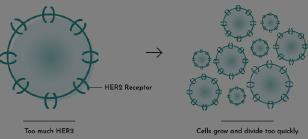

In [15]:
display.display(display.Image(base64.b64decode(relevant_images[0])))